# Template fits

In applications we are interested in separating a signal component from background components, we often fit parameteric models to data. Sometimes constructing a parametric model for some component is difficult. In that case, one fits a template instead which may be obtained from simulation or from a calibration sample in which a pure component can be isolated.

The challenge then is to propagate the uncertainty of the template into the result. The template is now also estimated from a sample (be it simulated or a calibration sample), and the uncertainty associated to that can be substantial. We investigate different approaches for template fits, including the Barlow-Beeston and Barlow-Beeston-lite methods.

In [59]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, BarlowBeestonLite
import numpy as np
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize
import matplotlib.pyplot as plt
from IPython.display import display

As a toy example, we generate a mixture of two components: a normally distributed signal and exponentially distributed background.

In [60]:
rng = np.random.default_rng(2)

ndata = 1000
nmc = 150
fsig = 0.25
b = truncexpon(1, 0, 2).rvs(size=int((1-fsig) * ndata), random_state=rng)
s = norm.rvs(1, 0.1, size=int(fsig * ndata), random_state=rng)
x = np.append(b, s)

bins = 15
w, xe = np.histogram(x, bins=bins, range=(0, 2))

b_mc = truncexpon(1, 0, 2).rvs(size=int(0.5 * nmc), random_state=rng)
s_mc = norm.rvs(1, 0.1, size=int(0.5 * nmc), random_state=rng)

w_mc = np.array([
    np.histogram(b_mc, bins=bins, range=(0, 2))[0],
    np.histogram(s_mc, bins=bins, range=(0, 2))[0],
])

Data is visualized on the left-hand side. The fit templates are shown on the right-hand side.

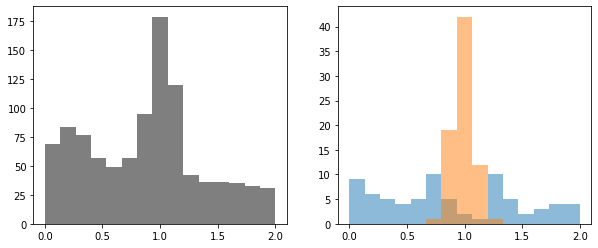

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].stairs(w, xe, fill=True, color="k", alpha=0.5, label="data")
for i, wi in enumerate(w_mc):
    ax[1].stairs(wi, xe, fill=True, alpha=0.5, label=f"template {i}")

## Bootstrapping template uncertainties

Here, we perform a standard fit and pretend that the templates have no uncertainties. Then we repeat this fit many times with templates that are fluctuated around the actual values assuming a Poisson distribution.

There is no builtin cost function in iminuit for a template fit, so we write a simple cost function for this case.

In [62]:
def cost(yields):
    mu = 0
    for y, c in zip(yields, w_mc):
        mu += y * c / np.sum(c)
    r = poisson_chi2(w, mu)
    return r

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(w.shape)

starts = np.ones(2)
m = Minuit(cost, starts)
m.limits = (0, None)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 173.9 (chi2/ndof = 13.4)   │              Nfcn = 119              │
│ EDM = 6.87e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    667    │    27     │            │            │    0    │         │       │
│ 1 │ x1   │    333    │    20     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────┐
│    │    x0    x1 │
├────┼─────────────┤
│ x0 │   740 -72.9 │
│ x1 │ -72.9   406 │
└────┴─────────────┘

The uncertainties reported by the fit correspond to the uncertainty in the data, but not the uncertainty in the templates. The chi2/ndof is also very large, since the uncertainties in the template are not considered in the fit.

To obtain the latter, we bootstrap the templates 1000 times and compute the covariance of the fitted results.

In [63]:
b = 1000
rng = np.random.default_rng(1)
pars = []
for ib in range(b):
    w_mc_i = rng.poisson(w_mc)

    def cost(yields):
        mu = 0
        for y, c in zip(yields, w_mc_i):
            mu += y * c / np.sum(c)
        r = poisson_chi2(w, mu)
        return r
    
    mi = Minuit(cost, m.values[:])
    mi.errordef = Minuit.LEAST_SQUARES
    mi.limits = (0, None)
    mi.strategy = 0
    mi.migrad()
    assert mi.valid
    pars.append(mi.values[:])
cov2 = np.cov(np.transpose(pars), ddof=1)

We print the uncertainties from the different stages and the correlation between the two yields.

To obtain the full error, we can simply add the covariance matrices from the original fit and the bootstrap.

In [64]:
cov1 = m.covariance

for title, cov in zip(("fit", "bootstrap", "fit+bootstrap"), 
                      (cov1, cov2, cov1 + cov2)):
    print(title)
    for label, p, e in zip(("x0", "x1"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / np.prod(np.diag(cov)) ** 0.5:.2f}")

fit
  x0 667 +- 27
  x1 333 +- 20
  correlation -0.13
bootstrap
  x0 667 +- 33
  x1 333 +- 26
  correlation -0.81
fit+bootstrap
  x0 667 +- 43
  x1 333 +- 33
  correlation -0.54


The bootstrapped template errors are slightly larger than the fit errors, since the sample used to generate the templates is smaller than the data sample. The bootstrapped errors for both yields are equal and the correlation is almost -1, since the data sample is fixed in each iteration. Under these conditions, a change in the templates can only increase the yield of one component at an equal loss for the other component.

## Template fit with nuisance parameters

As described by [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W), the correct approach for this problem from first principles is to treat the true bin contents for the templates as unknown and introduce a nuisance parameter for each bin entry in the template. The likelihood is then built from the combined likelihoods of fitting the nuisance parameters to the template contents and the likelihood to describe the data sample based on templates build from the nuisance parameters.

In principle, this problem can be handled straight-forwardly with Minuit, but it leads to the introduction of a large number of nuisance parameters, one for each entry in each template.

For the fit to fully converge, it is necessary to increae the call limit, since the limit set by Minuit's heuristic is too tight for this application.

In [65]:
def cost(par):
    yields = par[:2]
    nuisances = par[2:]
    b = nuisances[:bins]
    s = nuisances[bins:]
    mu = 0
    for y, c in zip(yields, (b, s)):
        mu += y * c / np.sum(c)
    r = poisson_chi2(w, mu) + poisson_chi2(w_mc[0], b) + poisson_chi2(w_mc[1], s)
    return r

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(w.shape) + np.prod(w_mc.shape)

m1 = Minuit(cost, np.ones(2 + len(w_mc[0]) * 2))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.92 (chi2/ndof = 1.5)    │             Nfcn = 18487             │
│ EDM = 0.000118 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    680    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    320    │    40     │            │            │    0    │         │       │
│ 2 │ x2   │    7.7    │    1.3    │            │            │    0    │         │       │
│ 3 │ x3   │    8.9    │    1.4    │            │            │    0    │         │       │
│ 4 │ x4   │    8.1    │    1.3    │            │            │    0    │         │       │
│ 5 │ x5   │    6.0    │    1.1    │            │            │    0    │         │       │
│ 6 │ x6   │    5.3    │    1.0    │            │            │    0    │         │       │
│ 7 │ x7   │    6.3    │    1.1    │            │            │    0    │         │       │
│ 8 │ x8   │    3.5    │    1.3    │            │            │    0    │         │       │
│ 9 │ x9   │    1.8    │    1.2    │            │            │    0    │         │       │
│ 10│ x10  │    3.8    │    2.7    │            │            │    0    │         │       │
│ 11│ x11  │    4.9    │    0.9    │            │            │    0    │         │       │
│ 12│ x12  │    4.1    │    0.8    │            │            │    0    │         │       │
│ 13│ x13  │    3.8    │    0.8    │            │            │    0    │         │       │
│ 14│ x14  │    3.8    │    0.8    │            │            │    0    │         │       │
│ 15│ x15  │    3.7    │    0.7    │            │            │    0    │         │       │
│ 16│ x16  │    3.5    │    0.7    │            │            │    0    │         │       │
│ 17│ x17  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 18│ x18  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 19│ x19  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 20│ x20  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 21│ x21  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 22│ x22  │    0.8    │    0.7    │            │            │    0    │         │       │
│ 23│ x23  │   16.0    │    3.1    │            │            │    0    │         │       │
│ 24│ x24  │    39     │     6     │            │            │    0    │         │       │
│ 25│ x25  │    18     │     5     │            │            │    0    │         │       │
│ 26│ x26  │    0.7    │    0.6    │            │            │    0    │         │       │
│ 27│ x27  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 28│ x28  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 29│ x29  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 30│ x30  │    0.0    │    0.4    │            │            │    0    │         │   

The result of this fit is comparable to the bootstrap method for this example, but the chi2/ndof is now reasonable and the uncertainties are correct without further work. This method should perform better than the bootstrap method, if the count per bin in the templates is small.

Another advantage is of this technique is that one can profile over the likelihood to obtain a 2D confidence regions, which is not possible with the bootstrap technique.

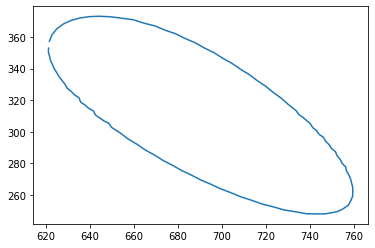

In [66]:
c1 = m1.mncontour("x0", "x1")
plt.plot(c1[:,0], c1[:, 1])

A possible refinement of the previous method is to perform a nested fit, which hides the nuisance parameters from Minuit. The idea here to construct an outer cost function, which only has the yields as parameters. Inside this cost function, the optimum nuisance parameters are found for the current yields (which are then considered fixed). Technically, this is achieved by calling a minimizer inside the cost function to solve the sub-problem.

It is important in this application to adjust Minuit's expectation of how accurate the cost function is computed. Usually, Minuit performs its internal calculations under the assumption that the cost function is accurate to machine precision. This is not necessarily the case when another minimizer is used internally to optimize the inner function. We perform the internal minimization with SciPy, which allows us to set the tolerance. We set it here to 1e-6, which is sufficient for this problem and saves time on the internal minimisation. We then instruct Minuit to expect only this precisione.

In [67]:
precision = 1e-6

def cost(yields):

    def inner(nuisance):
        b = nuisance[:bins]
        s = nuisance[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * c / np.sum(c)
        r = poisson_chi2(w, mu) + poisson_chi2(w_mc[0], b) + poisson_chi2(w_mc[1], s)
        return r

    bounds = np.zeros((2 * bins, 2))
    bounds[:, 1] = np.inf
    r = minimize(inner, w_mc.flatten(), bounds=bounds, tol=precision)
    assert r.success
    return r.fun

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(w.shape)

m2 = Minuit(cost, np.ones(2))
m2.precision = precision
m2.limits = (0, None)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.92 (chi2/ndof = 1.5)    │              Nfcn = 156              │
│ EDM = 0.00149 (Goal: 0.0002)     │            time = 7.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    680    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    320    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 2.19e+03 -1.5e+03 │
│ x1 │ -1.5e+03 1.82e+03 │
└────┴───────────────────┘

We obtain the same result, but the runtime is much longer (factor 10 in this case), which disfavors this technique compared to the straight-forward fit. The minimization is not as efficient, because Minuit cannot exploit correlations between the internal and the external parameters that allow it to converge it faster to the total optimum.

## Barlow-Beeston lite

The method described by [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W) solves the problem similary to the nested fit described above. The noticed a transformation which allows one to simplify the inner optimisation, so that it can be solved independently bin-by-bin by numerically finding a root of a score function. Unfortuntely, their approach introduces discontinuities in the log-likelihood as noted by [Conway, PHYSTAT 2011, https://arxiv.org/abs/1103.0354](https://doi.org/10.48550/arXiv.1103.0354). To address this, Conway proposes a simplified treatment where the uncertainty in the template is described by a multiplicative factor constrained by a Gaussian. With this simplification, the optimal nuisance parameters can be found by bin-by-bin by solving a quadratic equation which has only one allowed solution.

In [68]:
c = BarlowBeestonLite(w, w_mc)
m3 = Minuit(c, 1, 1)
m3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.69 (chi2/ndof = 1.5)    │              Nfcn = 152              │
│ EDM = 1.12e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.80e3   │  0.12e3   │            │            │         │         │       │
│ 1 │ x1   │    360    │    60     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  1.39e+04 -1.43e+03 │
│ x1 │ -1.43e+03  3.48e+03 │
└────┴─────────────────────┘

In [69]:
for title, m in zip(("full fit", "Barlow-Beeston-lite"), (m1, m3)):
    print(title)
    cov = m.covariance
    for label, p, e in zip(("x0", "x1"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / (cov[0, 0] * cov[1, 1]) ** 0.5:.2f}")

full fit
  x0 684 +- 47
  x1 316 +- 43
  correlation -0.76
Barlow-Beeston-lite
  x0 797 +- 118
  x1 360 +- 59
  correlation -0.21


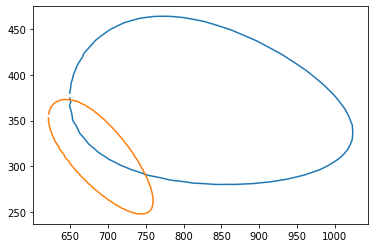

In [70]:
c3 = m3.mncontour("x0", "x1")
plt.plot(c3[:,0], c3[:, 1], label="BBL")
plt.plot(c1[:,0], c1[:, 1], label="ML");